# Climate change attribution

In this example notebook we will perform climate change atttribution by means of fingerprinting the effects of both natural and antropogenic impacts on global mean surface temperature.

### Step 1: load necessary packages

In [1]:
# Install packages
!pip install nc_time_axis # install nc_time_axis using pip

# Import necessary packages
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import xesmf as xe
import cartopy
from tqdm import tqdm  # Fancy progress bars for our loops!
import intake
import nc_time_axis
import xhistogram
import cartopy.crs as ccrs
import cartopy.util
import matplotlib

%matplotlib inline
plt.rcParams['figure.figsize'] = 12, 6
%config InlineBackend.figure_format = 'retina' 

### Step 2: launch dask cluster

In this step we launch the dask cluster to ease the computation

In [2]:
from dask.distributed import Client
from dask_gateway import Gateway

gateway = Gateway()  # connect to Gateway
cluster = gateway.new_cluster()  # create cluster

cluster.adapt(minimum=4, maximum=40)
cluster # will launch an GUI interface where you can change the cluster dimensions

client = Client(cluster)  # connect Client to Cluster
client

<Client: 'tls://10.51.220.22:8786' processes=0 threads=0, memory=0 B>

### Step 3: define functions

Here we define the functions needed to perform the analysis of the data. For more explanation on the functions, check ctb3311_notebook1 on spatio-temporal analysis.

In [3]:
# Function to preprocess the data and rename dimensions + drop redundant variables
def preprocess(ds):
    # rename spatial dimensions if necessary
    if ('longitude' in ds.dims) and ('latitude' in ds.dims):
        ds = ds.rename({'longitude':'lon', 'latitude': 'lat'}) # some models labelled dimensions differently...
        
    ds = xr.decode_cf(ds) # temporary hack, not sure why I need this but has to do with calendar-aware metadata on the time variable
    time_slice = slice('1880','2019') # specific years that bracket our period of interest
    ds = ds.sel(time=time_slice) # subset the data for the time period of interest
    
    # drop redundant variables (like "height: 2m")
    for coord in ds.coords:
        if coord not in ['lat','lon','time']:
            ds = ds.drop(coord)
    
    return ds.squeeze()

# Function to calculate area-weighted global mean
def globalmean(ds):
    ## Calculate global-mean of our variable by accounting for different areas corresponding 
    ## to different size of lat/lon grid points
    cos_lat_2d = np.cos(np.deg2rad(ds['lat'])) * xr.ones_like(ds['lon']) # effective area weights
    gm = (
        (ds[var] * cos_lat_2d).sum(dim=['lat','lon']) /cos_lat_2d.sum(dim=['lat','lon'])
    )
    return gm.squeeze().compute() # squeeze for removing  the dimensions of length 1 and compute to force the dask lazy computing https://tutorial.dask.org/01x_lazy.html

# Function to calculate monthly anomaly
def monthly_anom(x):
    return (x - x.mean('time'))

# Function to calculate mean over time
def mean_time(x):
    return x.mean('time')

### Step 4: read the observations

Here we are going to load the observed global mean temperature data set from [GISTEMP v4](https://data.giss.nasa.gov/gistemp/), which is also available in this notebook in the data folder.

In [4]:
# Read the observations as a panda dataframe
import csv
obs = pd.read_csv('data/GLB_Ts+dSST.csv',skiprows=0,header=1,dtype=np.float,na_values='***')
# Convert it into an xarray with Year as a coordinate
xobs = obs.to_xarray().set_coords('Year').swap_dims({"index": "Year"})
xobs

<xarray.Dataset>
Dimensions:  (Year: 141)
Coordinates:
    index    (Year) int64 0 1 2 3 4 5 6 7 8 ... 133 134 135 136 137 138 139 140
  * Year     (Year) float64 1.88e+03 1.881e+03 1.882e+03 ... 2.019e+03 2.02e+03
Data variables:
    Jan      (Year) float64 -0.17 -0.19 0.18 -0.28 -0.12 ... 1.02 0.82 0.93 1.17
    Feb      (Year) float64 -0.23 -0.13 0.15 -0.36 -0.07 ... 1.14 0.85 0.95 1.24
    Mar      (Year) float64 -0.08 0.04 0.05 -0.12 -0.35 ... 1.16 0.9 1.18 1.19
    Apr      (Year) float64 -0.15 0.06 -0.15 -0.17 -0.39 ... 0.94 0.9 1.02 1.16
    May      (Year) float64 -0.09 0.07 -0.14 -0.17 -0.34 ... 0.9 0.83 0.86 nan
    Jun      (Year) float64 -0.2 -0.18 -0.22 -0.07 -0.35 ... 0.72 0.79 0.92 nan
    Jul      (Year) float64 -0.17 0.01 -0.15 -0.06 -0.31 ... 0.82 0.83 0.94 nan
    Aug      (Year) float64 -0.09 -0.02 -0.06 -0.13 -0.26 ... 0.87 0.77 0.94 nan
    Sep      (Year) float64 -0.14 -0.14 -0.14 -0.2 -0.26 ... 0.79 0.8 0.92 nan
    Oct      (Year) float64 -0.22 -0.21 -0.23 -0.1 -0.24 ... 0.9 1.01 1.02 nan
    Nov      (Year) float64 -0.21 -0.17 -0.15 -0.22 -0.32 ... 0.89 0.83 1.0 nan
    Dec      (Year) float64 -0.17 -0.06 -0.35 -0.1 -0.3 ... 0.95 0.92 1.1 nan
    J-D      (Year) float64 -0.16 -0.08 -0.1 -0.16 -0.28 ... 0.92 0.85 0.98 nan
    D-N      (Year) float64 nan -0.09 -0.08 -0.18 -0.26 ... 0.92 0.86 0.97 nan
    DJF      (Year) float64 nan -0.16 0.09 -0.33 -0.1 ... 1.01 0.87 0.94 1.17
    MAM      (Year) float64 -0.11 0.06 -0.08 -0.15 -0.36 ... 1.0 0.88 1.02 nan
    JJA      (Year) float64 -0.15 -0.06 -0.14 -0.08 -0.31 ... 0.81 0.8 0.93 nan
    SON      (Year) float64 -0.19 -0.17 -0.17 -0.17 -0.28 ... 0.86 0.88 0.98 nan

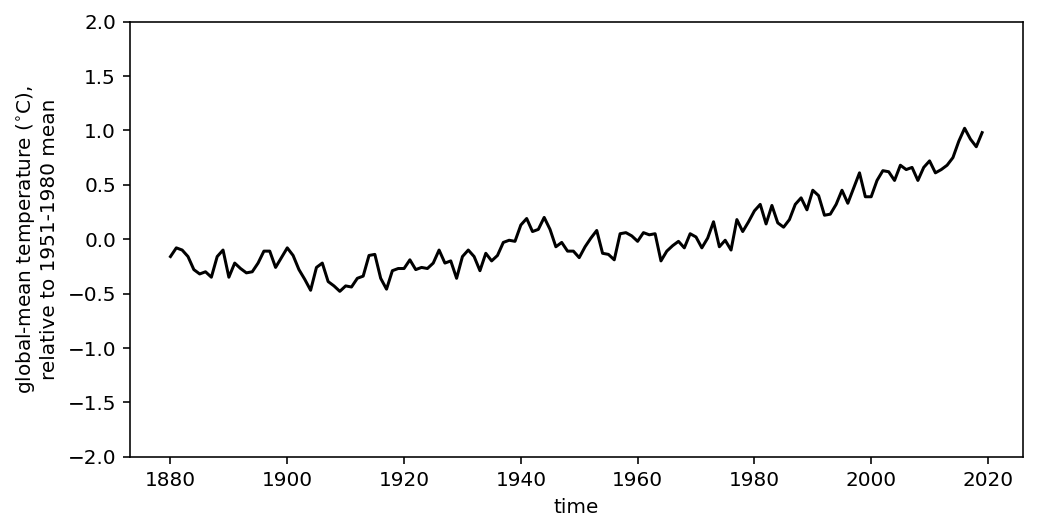

In [5]:
# Plot the observed annual mean temperature
plt.figure(figsize=(8,4))

plt.plot(xobs.Year,xobs['J-D'],color='black')
        
plt.xlabel('time')
plt.ylabel(r'global-mean temperature ($^{\circ}$C),'
           '\n'
           'relative to 1951-1980 mean')
# plt.xlim([1850,2020])
plt.ylim([-2,2]);

plt.savefig('historical_global_warming.png',dpi=100,bbox_inches='tight')

### Step 6: load the CMIP data and preprocess them

Now we are going to load the CMIP data from Google.

In [6]:
cat_url = "https://storage.googleapis.com/cmip6/pangeo-cmip6.json"
col = intake.open_esm_datastore(cat_url)
col

<pangeo-cmip6 catalog with 3902 dataset(s) from 268602 asset(s)>

In [7]:
var = 'tas'               # choose to look at atmospheric variables (A) saved at monthly resolution (mon)
table = 'Amon'            # choose to look at near-surface air temperature (tas) as our variable
member = 'r1i1p1f1'       # arbitrarily pick one realization for each model (i.e. just one set of initial conditions)
cat = col.search(require_all_on=["source_id"], # choose only models that have all have all of the following
                 experiment_id=['historical','hist-nat','piControl'], # require for each model that a historical, historical-natural-forcing and control run are available
                 table_id=table,             
                 variable_id=var,
                 member_id=member)
# List returned models grouped by model name
cat.df.groupby("source_id").nunique()
# Showing that there are five models that have data for all three experimenrs

activity_id  institution_id  source_id  experiment_id  \
source_id                                                             
BCC-CSM2-MR             2               1          1              3   
CESM2                   2               1          1              3   
CanESM5                 2               1          1              3   
IPSL-CM6A-LR            2               1          1              3   
MRI-ESM2-0              2               1          1              3   

              member_id  table_id  variable_id  grid_label  zstore  \
source_id                                                            
BCC-CSM2-MR           1         1            1           1       3   
CESM2                 1         1            1           1       3   
CanESM5               1         1            1           1       3   
IPSL-CM6A-LR          1         1            1           1       3   
MRI-ESM2-0            1         1            1           1       3   

              dcpp_init_year  
source_id                     
BCC-CSM2-MR                0  
CESM2                      0  
CanESM5                    0  
IPSL-CM6A-LR               0  
MRI-ESM2-0                 0

In [12]:
# Load the returned models into a data array
dset_dict = cat.to_dataset_dict(zarr_kwargs={'consolidated': True, 'decode_times': False})
dset_dict.keys()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


dict_keys(['CMIP.CCCma.CanESM5.historical.Amon.gn', 'CMIP.MRI.MRI-ESM2-0.historical.Amon.gn', 'CMIP.BCC.BCC-CSM2-MR.historical.Amon.gn', 'CMIP.IPSL.IPSL-CM6A-LR.historical.Amon.gr', 'CMIP.NCAR.CESM2.historical.Amon.gn', 'CMIP.NCAR.CESM2.piControl.Amon.gn', 'CMIP.BCC.BCC-CSM2-MR.piControl.Amon.gn', 'DAMIP.IPSL.IPSL-CM6A-LR.hist-nat.Amon.gr', 'DAMIP.MRI.MRI-ESM2-0.hist-nat.Amon.gn', 'DAMIP.NCAR.CESM2.hist-nat.Amon.gn', 'DAMIP.BCC.BCC-CSM2-MR.hist-nat.Amon.gn', 'DAMIP.CCCma.CanESM5.hist-nat.Amon.gn', 'CMIP.CCCma.CanESM5.piControl.Amon.gn', 'CMIP.IPSL.IPSL-CM6A-LR.piControl.Amon.gr', 'CMIP.MRI.MRI-ESM2-0.piControl.Amon.gn'])

Now let's apply some preprocessing, global mean and anomaly calculations on this data set.

In [13]:
# Apply preprocessing on dictionary of xarray datasets and return dictionary
ds_dict = {} # Create an empty dictionary
for name, ds in tqdm(dset_dict.items()): # loop over models
    # Add preprocessed data into dictionary
    ds_dict[name] = preprocess(ds) 

# Apply global mean on dictionary of xarray datasets and return dictionary
gm_dict = {} # Create an empty dictionary
for name, ds in tqdm(ds_dict.items()): # loop over models
    # Add Global mean to dictionary
    gm_dict[name] = globalmean(ds)
    
gm_anom_dict = {} # Create an empty dictionary
base_period = slice('1951','1980') # Is set to 1951-1980 to allow comparison with observations which are also defined for this period
for name, gm in tqdm(gm_dict.items()):  # loop over models
    try:
        # calculate monthly anomaly
        gm_anom = gm.groupby('time.month').map(monthly_anom).compute()
        # substract base period mean
        gm_anom = gm_anom - gm_anom.sel(time=base_period).mean(dim='time')
        # convert to annual anomalies
        gm_aanom = gm_anom.groupby('time.year').map(mean_time)

        gm_anom_dict[name] = gm_aanom.compute()
    except:
        continue

 87%|████████▋ | 13/15 [00:05<00:00,  3.26it/s]/srv/conda/envs/notebook/lib/python3.7/site-packages/xarray/coding/times.py:426: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/core/_asarray.py:85: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return array(a, dtype, copy=False, order=order)
100%|██████████| 15/15 [00:01<00:00, 10.67it/s]


### Step 7: separate the antropogenic and natural forcing

In this step we are going to load for one model `IPSL.IPSL-CM6A-LR` both the historical (i.e., all-forcing simulation of the recent past) and natural (i.e., historical natural-only run) runs and substract themn from each other to determine the antropogenic forcing only.

In [24]:
ds_his = gm_anom_dict['CMIP.IPSL.IPSL-CM6A-LR.historical.Amon.gr']
ds_nat = gm_anom_dict['DAMIP.IPSL.IPSL-CM6A-LR.hist-nat.Amon.gr']
ds_con = gm_anom_dict['CMIP.IPSL.IPSL-CM6A-LR.piControl.Amon.gr']
ds_ant = ds_his - ds_nat

Now let's apply a five year rolling mean on the data for the period 1880-2015:

In [25]:
period = slice(1880,2015)
ds_nat = ds_nat.sel(year=period).rolling(year=5, center=True).mean()
ds_ant = ds_ant.sel(year=period).rolling(year=5, center=True).mean()
ds_his = ds_his.sel(year=period).rolling(year=5, center=True).mean()
ds_con = ds_con.sel(year=period).rolling(year=5, center=True).mean()
ds_obs = xobs.sel(Year=period).rolling(Year=5, center=True).mean()

We now will convert the xarray.Dataset to a pandas dataframe in order to make combined dataset that can be be used in a linear regression for attributions studies.

In [26]:
# Create panda dataframes
pobs=ds_obs.to_dataframe()
phis=ds_his.to_dataframe(name='his')
pant=ds_ant.to_dataframe(name='ant')
pnat=ds_nat.to_dataframe(name='nat')
pcon=ds_con.to_dataframe(name='con')

In [27]:
# Combine the different model outputs into a combined dataframe and drop years with missing values
ds_combo = pant.combine_first(pnat).combine_first(pobs).combine_first(pcon).dropna()
ds_combo

Apr    Aug    D-N    DJF    Dec    Feb    J-D    JJA    Jan    Jul  \
year                                                                         
1883 -0.210 -0.154 -0.190 -0.180 -0.180 -0.146 -0.188 -0.188 -0.198 -0.168   
1884 -0.276 -0.210 -0.230 -0.216 -0.216 -0.218 -0.232 -0.230 -0.246 -0.204   
1885 -0.312 -0.266 -0.282 -0.334 -0.210 -0.360 -0.282 -0.256 -0.424 -0.224   
1886 -0.316 -0.268 -0.284 -0.334 -0.196 -0.358 -0.282 -0.266 -0.434 -0.232   
1887 -0.218 -0.256 -0.248 -0.310 -0.192 -0.308 -0.246 -0.228 -0.424 -0.184   
...     ...    ...    ...    ...    ...    ...    ...    ...    ...    ...   
2008  0.642  0.624  0.650  0.640  0.588  0.636  0.644  0.620  0.654  0.620   
2009  0.674  0.628  0.644  0.606  0.550  0.588  0.638  0.628  0.646  0.652   
2010  0.666  0.636  0.636  0.546  0.558  0.546  0.634  0.632  0.544  0.648   
2011  0.672  0.682  0.662  0.592  0.590  0.596  0.662  0.662  0.626  0.650   
2012  0.714  0.708  0.680  0.612  0.616  0.602  0.680  0.664  0.648  0.626   

      ...    Mar    May    Nov    Oct    SON    Sep       ant       con  \
year  ...                                                                 
1883  ... -0.126 -0.204 -0.218 -0.200 -0.206 -0.202 -0.653133  0.020413   
1884  ... -0.218 -0.264 -0.236 -0.212 -0.222 -0.220 -0.622044  0.037594   
1885  ... -0.298 -0.294 -0.256 -0.234 -0.244 -0.242 -0.610184  0.122564   
1886  ... -0.354 -0.302 -0.204 -0.210 -0.214 -0.224 -0.572336  0.156157   
1887  ... -0.272 -0.234 -0.206 -0.212 -0.212 -0.218 -0.572476  0.174792   
...   ...    ...    ...    ...    ...    ...    ...       ...       ...   
2008  ...  0.710  0.618  0.724  0.656  0.676  0.644  0.843069 -0.006019   
2009  ...  0.714  0.622  0.696  0.650  0.660  0.630  0.811683  0.030295   
2010  ...  0.684  0.640  0.738  0.690  0.694  0.652  0.940087  0.018853   
2011  ...  0.670  0.666  0.770  0.698  0.718  0.684  0.994364 -0.007777   
2012  ...  0.720  0.704  0.744  0.728  0.726  0.708  0.883445 -0.023848   

      index       nat  
year                   
1883    3.0 -0.082643  
1884    4.0 -0.149315  
1885    5.0 -0.177486  
1886    6.0 -0.213312  
1887    7.0 -0.183376  
...     ...       ...  
2008  128.0 -0.102167  
2009  129.0 -0.087346  
2010  130.0 -0.131562  
2011  131.0 -0.124636  
2012  132.0 -0.060854  

[130 rows x 22 columns]

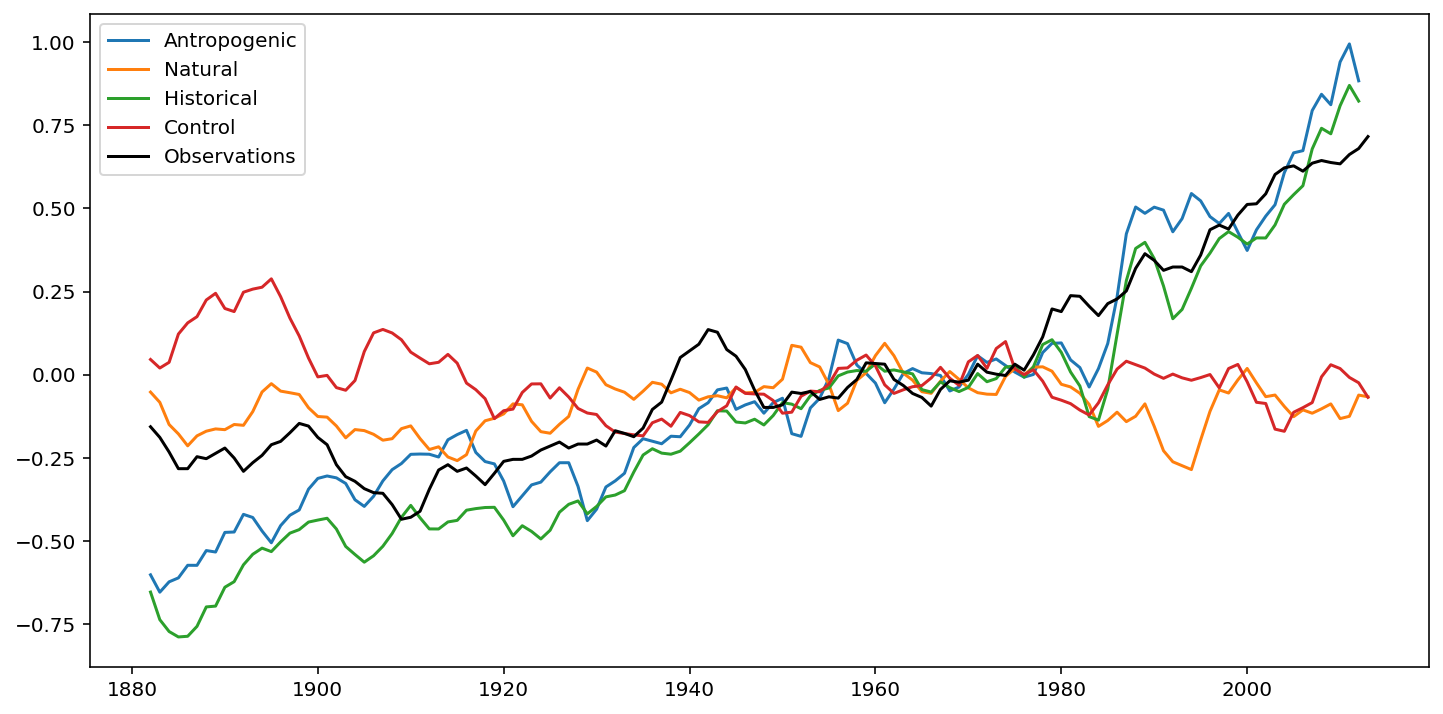

In [32]:
# Create a plot of the different data sets
plt.plot(ds_ant.year,ds_ant,label='Antropogenic')
plt.plot(ds_nat.year,ds_nat,label='Natural')
plt.plot(ds_his.year,ds_his,label='Historical')
plt.plot(ds_con.year,ds_con,label='Control')
plt.plot(ds_obs.Year,ds_obs['J-D'],color='black',label='Observations')
plt.legend()

### Step 8: Fingerprint the anthropogenic and natural forcing

In the next steps we are going to perform a linear regression analysis between the observed global mean warming (Y) and the different forcings (X's, with both athropogenic and natural forcing). For more details on the procedure and interpretation check the lecture week 4,  or [box 10.1 of chapter 10 of the IPCC AR5 WG1](https://www.ipcc.ch/site/assets/uploads/2018/02/WG1AR5_Chapter10_FINAL.pdf).

In [33]:
from sklearn import linear_model # load the linear regression package from sklearn
# Define the forcing parameters X
X = ds_combo[['ant','nat']]
# Define the observed change Y
Y = ds_combo[['J-D']]

In [34]:
# Build a linear regression model with sklearn
regr = linear_model.LinearRegression()
# Fit the model between X & Y
regr.fit(X, Y)

LinearRegression()

In [35]:
# Print the intercept and coefficients of the model
print('Intercept: \n', regr.intercept_)
print('Coefficients: \n', regr.coef_)

Intercept: 
 [0.07564519]
Coefficients: 
 [[0.72625977 0.49303666]]


In [36]:
# Or alternative load a more advanced linear regression toolbox
import statsmodels.api as sm
ols = sm.OLS(Y, sm.add_constant(X)) # define a linear regresion between Y & X
ols_result = ols.fit() # fit the model
ols_result.summary() # print the model summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    J-D   R-squared:                       0.876
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                     447.9
Date:                Wed, 27 May 2020   Prob (F-statistic):           2.96e-58
Time:                        21:24:50   Log-Likelihood:                 111.98
No. Observations:                 130   AIC:                            -218.0
Df Residuals:                     127   BIC:                            -209.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0756      0.013      5.605      0.000       0.049       0.102
ant            0.7263      0.025     29.443      0.000       0.677       0.775
nat            0.4930      0.113      4.349      0.000       0.269       0.717
==============================================================================
Omnibus:                        2.229   Durbin-Watson:                   0.147
Prob(Omnibus):                  0.328   Jarque-Bera (JB):                1.955
Skew:                           0.187   Prob(JB):                        0.376
Kurtosis:                       2.530   Cond. No.                         12.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

If we compare this with a regression where the observations in `Y` are replaced by the control run:

In [37]:
Y = ds_combo[['con']]
ols = sm.OLS(Y, sm.add_constant(X)) # define a linear regresion between Y & X
ols_result = ols.fit() # fit the model
ols_result.summary() # print the model summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    con   R-squared:                       0.152
Model:                            OLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                     11.36
Date:                Wed, 27 May 2020   Prob (F-statistic):           2.90e-05
Time:                        21:28:15   Log-Likelihood:                 122.25
No. Observations:                 130   AIC:                            -238.5
Df Residuals:                     127   BIC:                            -229.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0433      0.012     -3.470      0.001      -0.068      -0.019
ant           -0.0726      0.023     -3.186      0.002      -0.118      -0.028
nat           -0.3595      0.105     -3.432      0.001      -0.567      -0.152
==============================================================================
Omnibus:                        5.158   Durbin-Watson:                   0.148
Prob(Omnibus):                  0.076   Jarque-Bera (JB):                4.859
Skew:                           0.471   Prob(JB):                       0.0881
Kurtosis:                       3.106   Cond. No.                         12.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Step 9: interpretation

From this linear regression analysis we can now determine how model-simulated responses to natural and anthropogenic forcing need to be scaled to reproduce the observations. The coefficients (or scaling factors) accounts for possible errors in the amplitudes of the external forcing and the climatemodel’s response by scaling the signal patterns to best match the observations. If a chosen uncertainty range(e.g., 5–95%) does not include ‘0’, this indicates that the fingerprint is likely present in observations and hence detectable. If the signal is detected, but the estimated uncertainty range does not include ‘1’, this indicates that the model response has to be rescaled to match the observations. The model fingerprint, scaled with the range of scalings, thus provides an estimate of the range of forcing responses that areconsistent with the observed change ([Hegerli & Zwiers, 2011](https://onlinelibrary.wiley.com/doi/abs/10.1002/wcc.121)). 


In this case, for the IPSL-CM6A-LR model the best-fit gradient in the direction of anthropogenic warming is 0.73, indicating the model overestimates the magnitude of the observed response to anthropogenic forcing by about 27%. The best-fit gradient in the direction of natural changes is 0.49, indicating that the observed response to natural forcing is 49% of the model-simulated response. Moreover, we can see that both the natural and anthropogenic scaling factors do not include 0 in their 95% uncertainty interval (`0.68<ant<0.77` and `0.27<nat<0.72`), which implies that both natural and anthropogenic fingerprints can be detected in the observed global mean surface temperature.

If we compare the observation regression with the control-run regression, we see that the scaling factors change drastically (even become negative). This indicates that in a control run where the climate is not altered, we do not see the natural and anthropogenic fingerprints as could be expected.

### Step 10: fingerprinting for all models

How does this attribution look like when we apply it to all 5 models that have both historical and anthropogenic forcing?

Coefficients for BCC-BCC-CSM2-MR: 
 [[1.18404712 0.89571759]]
Coefficients for NCAR-CESM2: 
 [[0.89416872 0.40941733]]
Coefficients for CCCma-CanESM5: 
 [[0.71010761 0.74735307]]
Coefficients for IPSL-IPSL-CM6A-LR: 
 [[0.72625977 0.49303666]]
Coefficients for MRI-MRI-ESM2-0: 
 [[1.25367723 0.83529546]]


/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:44: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


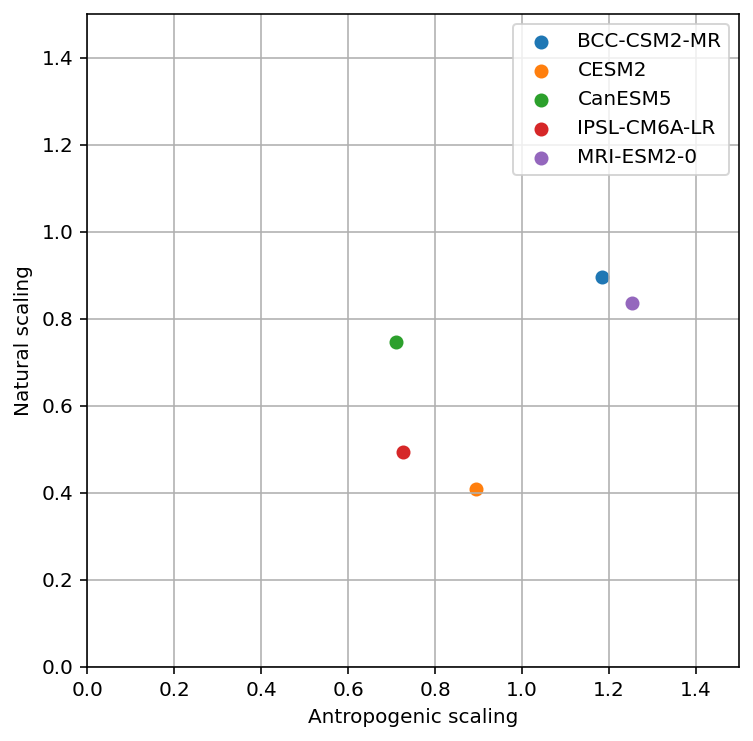

In [38]:
plt.figure()
for name, model in cat.df.groupby('source_id'): # loop over all models
    # Get unique names per model
    institution = model['institution_id'].unique()[0]
    source = model['source_id'].unique()[0]
    grid = model['grid_label'].unique()[0]

    # Load model settings based on name
    ds_his = gm_anom_dict['CMIP.' +institution+'.'+source+'.historical.Amon.'+grid]
    ds_nat = gm_anom_dict['DAMIP.'+institution+'.'+source+'.hist-nat.Amon.'+grid]
    ds_ant = ds_his - ds_nat
    
    # Subset and apply running mean
    ds_nat = ds_nat.sel(year=period).rolling(year=5, center=True).mean()
    ds_ant = ds_ant.sel(year=period).rolling(year=5, center=True).mean()
    ds_his = ds_his.sel(year=period).rolling(year=5, center=True).mean()

    # Create panda dataframes
    phis=ds_his.to_dataframe(name='his')
    pant=ds_ant.to_dataframe(name='ant')
    pnat=ds_nat.to_dataframe(name='nat')
    
    # Combine the different model outputs into a combined dataframe and drop years with missing values
    ds_combo = pant.combine_first(pnat).combine_first(pobs).dropna()
    
    # Define the forcing parameters X
    X = ds_combo[['ant','nat']]
    # Define the observed change Y
    Y = ds_combo[['J-D']]
    
    # Build a linear regression model with sklearn
    regr = linear_model.LinearRegression()
    # Fit the model between X & Y
    regr.fit(X, Y)
    
    print('Coefficients for '+institution+'-'+source+': \n', regr.coef_)
    plt.scatter(regr.coef_[0][0],regr.coef_[0][1],label=source)

plt.xlim(0,1.5)
plt.ylim(0,1.5)
plt.xlabel('Antropogenic scaling')
plt.ylabel('Natural scaling')
plt.grid(True)
plt.axes().set_aspect('equal')

plt.legend()

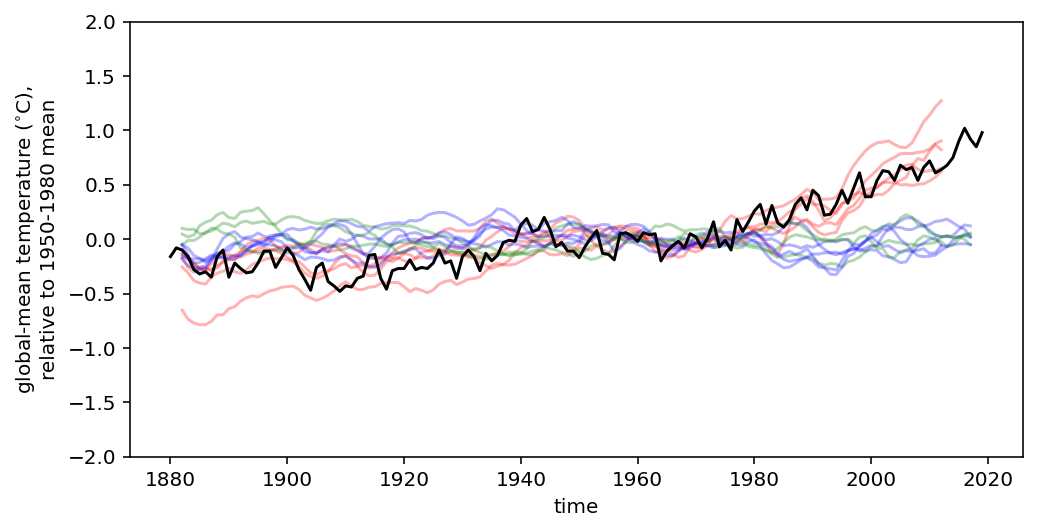

In [40]:
# And what if we plot time series
plt.figure(figsize=(8,4))
for name, ds in ds_dict.items():
    try:
        gm = gm_anom_dict[name].rolling(year=5, center=True).mean()
        if ds.experiment_id == 'historical':
            color = 'red'
        elif ds.experiment_id == 'piControl':
            color = 'green'
        else:
            color='blue'
        plt.plot(gm.year,gm,alpha=0.3,color=color)
    except:
        continue
plt.plot(xobs.Year,xobs['J-D'],color='black')
plt.xlabel('time')
plt.ylabel(r'global-mean temperature ($^{\circ}$C),'
           '\n'
           'relative to 1950-1980 mean')
plt.ylim([-2,2]);

plt.savefig('forcingTimeSeries.png',dpi=100,bbox_inches='tight')

From these analyses and figures, it is clear that the observed historical global mean temperature change can be attributed to both antropogenic and natural forcing in all models, but that the impact of antropogenic has been stronger.